In [1]:
import glob
import pandas as pd

all_files = glob.glob("../data/uk/*")

all_data_df = pd.concat((pd.read_csv(f) for f in all_files))

cleaned_df = all_data_df.dropna(subset=['LSOA name'])

k_and_c_data = cleaned_df[cleaned_df['LSOA name'].str.contains("Kensington and Chelsea")]

months = ['2024-01', '2024-02', '2024-03', '2024-04', '2024-05', '2024-06', '2024-07', '2024-08', '2024-09', '2024-10', '2024-11', '2024-12']

month_map = {
	'2024-01': 'Jan',
	'2024-02': 'Feb',
	'2024-03': 'Mar',
	'2024-04': 'Apr',
	'2024-05': 'May',
	'2024-06': 'Jun',
	'2024-07': 'Jul',
	'2024-08': 'Aug',
	'2024-09': 'Sep',
	# '2024-10': 'Oct',
	# '2024-11': 'Nov',
	# '2024-12': 'Dec'
}

monthly_data = {month_map[month]: k_and_c_data[k_and_c_data['Month'] == month] for month in month_map.keys()}


# 2024 crime by type in Kensington and Chelsea

In [2]:
import plotly.graph_objects as go

fig = go.Figure()

for crime_type in k_and_c_data['Crime type'].unique():
	monthly_counts = [monthly_data[month]['Crime type'].value_counts().get(crime_type, 0) for month in month_map.values()]
	fig.add_trace(go.Scatter(
		x=list(month_map.values()), 
		y=monthly_counts, 
		mode='lines+markers', 
		name=crime_type,
		fill='tozeroy',
		opacity=0.3
	))

fig.update_layout(
	title='Crimes by type in Kensington and Chelsea',
	xaxis_title='Month',
	yaxis_title='Number of crimes',
	legend_title='Crime Type'
)

fig.write_html("dashboard.html")

fig.show()

# A closer look at violent and sexual offences in Kensington and Chelsea in 2024

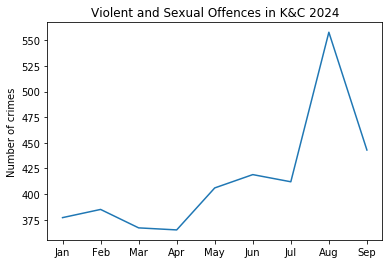

In [3]:

import matplotlib.pyplot as plt

vso_data = k_and_c_data[k_and_c_data['Crime type'].str.contains("Violence and sexual offences")].copy()
vso_data.to_csv("vso_data.csv")

vso_data.loc[:, 'Month'] = vso_data['Month'].map(month_map)
vso_data['Month'].value_counts().reindex(month_map.values()).plot(kind="line")

plt.title('Violent and Sexual Offences in K&C 2024')
plt.ylabel('Number of crimes')
plt.show()


In [4]:
import folium

center_lat = vso_data['Latitude'].mean()
center_lon = vso_data['Longitude'].mean()

map_crime = folium.Map(location=[center_lat, center_lon], zoom_start=12)

for loc, row in vso_data.iterrows():
    folium.Circle(
		location=[row['Latitude'], row['Longitude']],
		popup=f"Month: {row['Month']}<br>Outcome: {row['Last outcome category']}",
		radius=2,
		fill=True, 
		color="red",
	).add_to(map_crime)

map_crime.save("crime_map.html")